In [23]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import sys
import matplotlib as mpl
from matplotlib.colors import LogNorm

sys.path.append("../src/")
from tapm import utils

In [37]:
args, y0 = utils.read_params(filename="model_params_HIVandSTI.txt")
lambdaP = 1 / 360  # 1,2,4
betaSTI = 0.008  # 0.0016 *[3, 5, 7]

In [38]:
# test of new equations

def Splus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (-Bprime(P,H)+np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))
def Sminus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (-Bprime(P,H)-np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))

def Aprime(P,H):
    return kappa(P,H)*(a(P,H)+b(P,H)) * (C(P,H)*args['Sigma']-args['mu'])
def Bprime(P,H):
    return kappa(P,H)*(a(P,H)+b(P,H)) * (args['Phi']-C(P,H)*args['Sigma'])
def Cprime(P,H):
    return -(C(P,H)*args['Sigma']+args['Phi']-args['Sigma'])
def C(P,H):
    return args['gamma_STI']*a(P,H) + args['gammaT_STI']/(args['gammaT_STI']+args['mu']) * (lambdaa(P,H)*a(P,H) + lambdas(P,H)*b(P,H))
def a(P,H):
    return args['psi']/(args['gamma_STI']+lambdaa(P,H)+args['mu'])
def b(P,H):
    return (1-args['psi'])/(lambdas(P,H)+args['mu'])
def kappa(P,H):
    return args['beta_STI'] * (1-m(P,H)*(1-P))
def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)
def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P
def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H
def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))
def R0(P, H):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (lambdas(P, H) + args["mu"])


Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0, 0.2, 10)

for P in Ps:
    for H in Hs:
        if True:#((Splus(P,H) < 0) or (Splus(P,H) > 1)):
            print("P: ",P," H: ",H," S+: ", Splus(P,H))
            print(Aprime(P,H), Bprime(P,H), Cprime(P,H))
        if True:#((Sminus(P,H) < 0) or (Sminus(P,H) > 1)):
            print("P: ",P," H: ",H," S-: ", Sminus(P,H))
            print(Aprime(P,H), Bprime(P,H), Cprime(P,H))

/tmp/ipykernel_61197/987929537.py:7: RuntimeWarning: invalid value encountered in sqrt
  return (-Bprime(P,H)+np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))
/tmp/ipykernel_61197/987929537.py:12: RuntimeWarning: invalid value encountered in sqrt
  return (-Bprime(P,H)-np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))


P:  0.0  H:  0.0  S+:  nan
-0.0001948185250257086 0.0001948185250257086 -6.17283950617284e-05
P:  0.0  H:  0.0  S-:  nan
-0.0001948185250257086 0.0001948185250257086 -6.17283950617284e-05
P:  0.0  H:  0.022222222222222223  S+:  nan
-9.678801944900333e-05 9.678801944900333e-05 -6.17283950617284e-05
P:  0.0  H:  0.022222222222222223  S-:  nan
-9.678801944900333e-05 9.678801944900333e-05 -6.17283950617284e-05
P:  0.0  H:  0.044444444444444446  S+:  nan
-6.42080024853327e-05 6.42080024853327e-05 -6.17283950617284e-05
P:  0.0  H:  0.044444444444444446  S-:  nan
-6.42080024853327e-05 6.42080024853327e-05 -6.17283950617284e-05
P:  0.0  H:  0.06666666666666667  S+:  1
-4.7894447271962874e-05 4.7894447271962874e-05 -6.17283950617284e-05
P:  0.0  H:  0.06666666666666667  S-:  1
-4.7894447271962874e-05 4.7894447271962874e-05 -6.17283950617284e-05
P:  0.0  H:  0.08888888888888889  S+:  1
-3.807630281743887e-05 3.807630281743887e-05 -6.17283950617284e-05
P:  0.0  H:  0.08888888888888889  S-:  1
-3.

## All the equations we need to calculate Nobs and Nreal as well as their derivatives with respect to H and P

The equations I took from the Latex (double checked the implementation, but if there were mistakes in the Latex they are also here)

Derivatives Laura calculated by hand, double checked by Philipp and Antonio

In [11]:
# functions we need


def Nobs(P, H): # corrected for influx
    return lambdas(P, H) * Is(P, H) + lambdaa(P, H) * Ia(P, H)


def Nreal(P, H): # corrected for influx
    return betaSTI * ((1 - m(P, H)) * (1 - P) + P) * S(P, H) * (Is(P, H) + Ia(P, H)) + args['Sigma']


def Is(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"] * Ia(P, H)


def Ia(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return ((args["mu"] + args["gammaT_STI"]) * (1 / R0(P, H) - 1)) / (
            -b(P, H) / args["psi"]
            + args["gamma_STI"]
            - args["gammaT_STI"]
            * (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"])
        )


def S(P, H):
    if R0(P, H) < 1:
        return 1
    else:
        #return a(P,H)/((1-args['psi'])*alpha(P,H)) * Is(P,H)/(Ia(P,H) + Is(P,H)) # no influx
        #return 1 / R0(P, H) # no influx
        return 1/(alpha(P,H) * (Ia(P,H)+Is(P,H))) * ((lambdas(P,H)+args['mu'])/(1-args['psi']) * Is(P,H) - args['Sigma']) # influx


def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)


def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P


def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H


def betaHIV(P, H):
    return args["beta_HIV"] * (1 - m(P, H))


def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))


def a(P, H):
    return lambdas(P, H) + args["mu"]


def b(P, H):
    return args["gamma_STI"] + lambdaa(P, H) + args["mu"]


def R0(P, H):
    return args["psi"] * alpha(P, H) / b(P, H) + (1 - args["psi"]) * alpha(P, H) / a(P, H)


def alpha(P, H):
    return betaSTI * (1 - m(P, H) * (1 - P))

In [12]:
# derivatives of functions
# dx/dy names dx_dy for easier readability


def dNobs_dP(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return (Is(P, H) * dlambdas_dP(P, H) + Ia(P, H) * dlambdaa_dP(P, H) + lambdas(P, H) * dIs_dP(P, H) + lambdaa(P, H) * dIa_dP(P, H))


def dNobs_dH(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return (Is(P, H) * dlambdas_dH(P, H) + Ia(P, H) * dlambdaa_dH(P, H) + lambdas(P, H) * dIs_dH(P, H) + lambdaa(P, H) * dIa_dH(P, H))


def dNreal_dP(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return betaSTI * S(P, H) * (((1 - m(P, H)) * (1 - P) + P) * (dIs_dP(P, H) + dIa_dP(P, H))+ (Is(P, H) + Ia(P, H)) * m(P, H)) + Nreal(P, H) / S(P, H) * dS_dP(P, H)


def dNreal_dH(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return betaSTI * S(P, H) * (((1 - m(P, H)) * (1 - P) + P) * (dIs_dH(P, H) + dIa_dH(P, H))+ (Is(P, H) + Ia(P, H)) * ((1 - P) * (-dm_dH(P, H)))) + Nreal(P, H) / S(P, H) * dS_dH(P, H)


def dIs_dP(P, H):
    return (
        1 / a(P, H) * (1 - args["psi"]) / args["psi"] * Ia(P, H) * db_dP(P, H)
        + b(P, H)
        * (1 - args["psi"])
        / args["psi"]
        * Ia(P, H)
        * (-1 / (a(P, H)) ** 2)
        * da_dP(P, H)
        + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"] * dIa_dP(P, H)
    )


def dIs_dH(P, H):
    return (
        1 / a(P, H) * (1 - args["psi"]) / args["psi"] * Ia(P, H) * db_dH(P, H)
        + b(P, H)
        * (1 - args["psi"])
        / args["psi"]
        * Ia(P, H)
        * (-1 / (a(P, H)) ** 2)
        * da_dH(P, H)
        + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"] * dIa_dH(P, H)
    )


def dIa_dP(P, H):
    part1 = ((args["mu"] + args["gammaT_STI"])/ (-b(P, H) / args["psi"] + args["gamma_STI"]- args["gammaT_STI"]* (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"]))* (-1 / (R0(P, H))**2)* dR0_dP(P, H))
    part2 = (((args["mu"] + args["gammaT_STI"]) * (1 / R0(P, H) - 1))/ (-((b(P, H) / args["psi"]+ args["gamma_STI"]- args["gammaT_STI"]* (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"]))**2))* 
             (-1 / args["psi"] * db_dP(P, H)- args["gammaT_STI"]/ a(P, H)* (1 - args["psi"])/ args["psi"]* db_dP(P, H)+ args["gammaT_STI"]* b(P, H)/ (a(P, H))**2* (1 - args["psi"])/ args["psi"]* da_dP(P, H)))
    return part1 + part2


def dIa_dH(P, H):
    part1 = (
        (args["mu"] + args["gammaT_STI"])
        / (
            -b(P, H) / args["psi"]
            + args["gamma_STI"]
            - args["gammaT_STI"]
            * (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"])
        )
        * (-1 / (R0(P, H)) ** 2)
        * dR0_dH(P, H)
    )
    part2 = (((args["mu"] + args["gammaT_STI"]) * (1 / R0(P, H) - 1))/ (-((b(P, H) / args["psi"]+ args["gamma_STI"]- args["gammaT_STI"]* (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"]))** 2 ))
        * (-1 / args["psi"] * db_dH(P, H)- args["gammaT_STI"]/ a(P, H)* (1 - args["psi"])/ args["psi"]* db_dH(P, H)+ args["gammaT_STI"]* b(P, H)/ (a(P, H)) ** 2* (1 - args["psi"])/ args["psi"]* da_dH(P, H)))
    return part1 + part2


def dS_dP(P, H):
    # without influx
    #part1 = (1/ ((1 - args["psi"]) * alpha(P, H))* Is(P, H)/ (Ia(P, H) + Is(P, H)) * da_dP(P, H))
    #part2 = (a(P, H)/ ((1 - args["psi"]) * alpha(P, H))* 1/ (Ia(P, H) + Is(P, H))* dIs_dP(P, H))
    #part3 = (a(P, H)/ ((1 - args["psi"]) * alpha(P, H))* Is(P, H)* (-1 / (Ia(P, H) + Is(P, H)) ** 2)* (dIa_dP(P, H) + dIs_dP(P, H)))
    #part4 = (a(P, H)/ (-(1 - args["psi"]) * (alpha(P, H)) ** 2)* Is(P, H)/ (Ia(P, H) + Is(P, H))* dalpha_dP(P, H))

    # with influx
    part1 = -1/(alpha(P,H)**2 * (Ia(P,H)+Is(P,H))) * ((lambdas(P,H)+args['mu'])/(1-args['psi']) * Is(P,H) - args['Sigma']) * dalpha_dP(P,H)
    part2 = -1/(alpha(P,H) * (Ia(P,H)+Is(P,H))**2) * ((lambdas(P,H)+args['mu'])/(1-args['psi']) * Is(P,H) - args['Sigma']) * (dIa_dP(P,H) + dIs_dP(P,H))
    part3 = 1/(alpha(P,H) * (Ia(P,H)+Is(P,H))) * Is(P,H)/(1-args['psi']) * dlambdas_dP(P,H)
    part4 = 1/(alpha(P,H) * (Ia(P,H)+Is(P,H))) * (lambdas(P,H)+args['mu'])/(1-args['psi']) * dIs_dP(P,H)

    return part1 + part2 + part3 + part4


def dS_dH(P, H):
    # without influx
    #part1 = (1/ ((1 - args["psi"]) * alpha(P, H))* Is(P, H)/ (Ia(P, H) + Is(P, H))* da_dH(P, H))
    #part2 = (a(P, H)/ ((1 - args["psi"]) * alpha(P, H))* 1/ (Ia(P, H) + Is(P, H)) * dIs_dH(P, H))
    #part3 = (a(P, H)/ ((1 - args["psi"]) * alpha(P, H))* Is(P, H)* (-1 / (Ia(P, H) + Is(P, H)) ** 2)* (dIa_dH(P, H) + dIs_dH(P, H)))
    #part4 = (a(P, H)/ (-(1 - args["psi"]) * (alpha(P, H)) ** 2)* Is(P, H)/ (Ia(P, H) + Is(P, H))* dalpha_dH(P, H))

    # with influx
    part1 = -1/(alpha(P,H)**2 * (Ia(P,H)+Is(P,H))) * ((lambdas(P,H)+args['mu'])/(1-args['psi']) * Is(P,H) - args['Sigma']) * dalpha_dH(P,H)
    part2 = -1/(alpha(P,H) * (Ia(P,H)+Is(P,H))**2) * ((lambdas(P,H)+args['mu'])/(1-args['psi']) * Is(P,H) - args['Sigma']) * (dIa_dH(P,H) + dIs_dH(P,H))
    part3 = 1/(alpha(P,H) * (Ia(P,H)+Is(P,H))) * Is(P,H)/(1-args['psi']) * dlambdas_dH(P,H)
    part4 = 1/(alpha(P,H) * (Ia(P,H)+Is(P,H))) * (lambdas(P,H)+args['mu'])/(1-args['psi']) * dIs_dH(P,H)

    return part1 + part2 + part3 + part4


def da_dP(P, H):
    return dlambdas_dP(P, H)


def da_dH(P, H):
    return dlambdas_dH(P, H)


def db_dP(P, H):
    return dlambdaa_dP(P, H)


def db_dH(P, H):
    return dlambdaa_dH(P, H)


def dR0_dP(P, H):
    return (
        args["psi"] * alpha(P, H) * (-1 / (b(P, H)) ** 2) * db_dP(P, H)
        + (1 - args["psi"]) * alpha(P, H) * (-1 / (a(P, H)) ** 2) * da_dP(P, H)
        + (args["psi"] / b(P, H) + (1 - args["psi"]) / a(P, H)) * dalpha_dP(P, H)
    )


def dR0_dH(P, H):
    return (
        args["psi"] * alpha(P, H) * (-1 / (b(P, H)) ** 2) * db_dH(P, H)
        + (1 - args["psi"]) * alpha(P, H) * (-1 / (a(P, H)) ** 2) * da_dH(P, H)
        + (args["psi"] / b(P, H) + (1 - args["psi"]) / a(P, H)) * dalpha_dH(P, H)
    )


def dalpha_dP(P, H):
    return betaSTI * m(P, H)


def dalpha_dH(P, H):
    return -betaSTI * (1 - P) * dm_dH(P, H)


def dlambdas_dP(P, H):
    return dlambdaa_dP(P, H)


def dlambdas_dH(P, H):
    return dlambdaa_dH(P, H)


def dlambdaa_dP(P, H):
    return -lambdaH(P, H) + lambdaP


def dlambdaa_dH(P, H):
    return (1 - P) * dlambdaH_dH(P, H)


def dlambdaH_dP(P, H):
    return 0


def dlambdaH_dH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] - args["c"] * args["beta_HIV"] * H * dm_dH(P, H)


def dbetaHIV_dP(P, H):
    return 0


def dbetaHIV_dH(P, H):
    return -args["beta_HIV"] * dm_dH(P, H)


def dm_dP(P, H):
    return 0


def dm_dH(P, H):
    return ((args["max_exp"] - args["min_exp"])/ args["tau_exp"] * np.exp(-H / args["tau_exp"]))

## Compare gradient (signs) of Nobs and Nreal

In [13]:
# analytical gradient, calculated by Laura, checked by Philipp and Antonio

Ps = np.linspace(0, 1, 201)
Hs = np.linspace(0, 0.2, 201)

dNobsdP = np.zeros((len(Hs), len(Ps)))
dNobsdH = np.zeros((len(Hs), len(Ps)))
dNrealdP = np.zeros((len(Hs), len(Ps)))
dNrealdH = np.zeros((len(Hs), len(Ps)))

for i, H in enumerate(Hs):
    for j, P in enumerate(Ps):
        dNobsdP[i, j] = dNobs_dP(P, H)
        dNobsdH[i, j] = dNobs_dH(P, H)
        dNrealdP[i, j] = dNreal_dP(P, H)
        dNrealdH[i, j] = dNreal_dH(P, H)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


KeyboardInterrupt: 

In [ ]:
# numerical gradient with jax.grad

if False:
    dNobs_num_func = jax.grad(Nobs, argnums=(0, 1))
    dNreal_num_func = jax.grad(Nreal, argnums=(0, 1))

    dNobs_num = np.zeros((len(Hs), len(Ps)))
    dNreal_num = np.zeros((len(Hs), len(Ps)))
    dNobs_signs_num = np.zeros((len(Hs), len(Ps)))
    dNreal_signs_num = np.zeros((len(Hs), len(Ps)))
    dNobs_dNreal_comparison_num = np.zeros((len(Hs), len(Ps)))

    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            dPobs, dHobs = dNobs_num_func(P, H)
            dNobs_num[i, j] = dPobs + dHobs
            dPreal, dHreal = dNreal_num_func(P, H)
            dNreal_num[i, j] = dPreal + dHreal
            dNobs_signs_num[i, j] = np.sign(dNobs_num[i, j])
            dNreal_signs_num[i, j] = np.sign(dNreal_num[i, j])
            dNobs_dNreal_comparison_num[i, j] = np.sign(dNobs_num[i, j]) + np.sign(
                dNreal_num[i, j]
            )

## Compare Nobs and Nreal (not derivatives)

In [14]:
Nobs_vals = np.zeros((len(Hs), len(Ps)))
Nreal_vals = np.zeros((len(Hs), len(Ps)))
Nobs_Nreal_vals_comparison = np.zeros((len(Hs), len(Ps)))

for i, H in enumerate(Hs):
    for j, P in enumerate(Ps):
        Nobs_vals[i, j] = Nobs(P, H)
        Nreal_vals[i, j] = Nreal(P, H)
        Nobs_Nreal_vals_comparison[i, j] = Nobs_vals[i, j] - Nreal_vals[i, j]

## Saving data for plots

In [15]:
# save stuff as npy files

with open(
    "../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g.npy"
    % (lambdaP * 360, betaSTI),
    "wb",
) as f:
    np.save(f, Ps)
    np.save(f, Hs)
    np.save(f, dNobsdP)
    np.save(f, dNobsdH)
    np.save(f, dNrealdP)
    np.save(f, dNrealdH)
    np.save(f, Nobs_vals)
    np.save(f, Nreal_vals)

## Final figure

/tmp/ipykernel_61197/2087526597.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


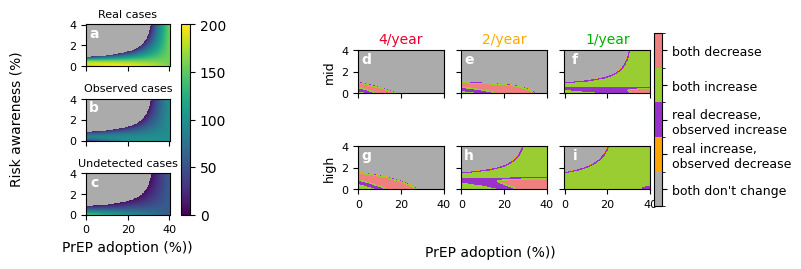

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors


# what we want to plot
Hs = np.linspace(0, 0.2, 201)
Ps = np.linspace(0, 1.0, 201)

lambda_P_values = [4 / 360.0, 2 / 360.0, 1 / 360.0]
lambda_P_labels = ["4/year", "2/year", "1/year"]
beta_STI_values = [0.0016 * 5.0, 0.0016 * 7.0]
beta_STI_labels = ["mid", "high"]
colors_stability = ["#E9002D", "#FFAA00", "#00B000"]

# Plot set-up
fig = plt.figure(figsize=(8.0, 2.5))
outer_grid = fig.add_gridspec(1, 2, width_ratios=[0.8, 2.5], wspace=0.7)

# Left side of the plot, Nobs, Nreal, Nreal-Nobs---------------------------------------------------------------------------------------------------
# set-up
left_grid = outer_grid[0].subgridspec(3, 1, hspace=0.7)
axs = []
for i in range(3):
    ax = fig.add_subplot(left_grid[i])
    axs.append(ax)
cmap = plt.get_cmap("viridis")
cmap.set_bad("#ABABAB")

# load data
with open("../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g.npy" % (1, 0.008),"rb") as f:
    Ps_plot = np.load(f)
    Hs_plot = np.load(f)
    dNobsdP_plot = np.load(f)
    dNobsdH_plot = np.load(f)
    dNrealdP_plot = np.load(f)
    dNrealdH_plot = np.load(f)
    Nobs_plot = np.load(f) * 100000
    Nreal_plot = np.load(f) * 100000

Nreal_minus_Nobs_plot = Nreal_plot - Nobs_plot
threshold_setbad = 0.00003 * 100000
Nobs_plot[Nobs_plot < threshold_setbad] = np.nan
Nreal_plot[Nreal_plot < threshold_setbad] = np.nan
Nreal_minus_Nobs_plot[Nreal_minus_Nobs_plot < threshold_setbad] = np.nan
results = [Nreal_plot, Nobs_plot, Nreal_minus_Nobs_plot]
titles = ["Real cases", "Observed cases", "Undetected cases"]

# plotting
for i, ax in enumerate(axs):
    for color in colors_stability:
        cax = ax.imshow(results[i],origin="lower",vmin=0,vmax=200,cmap=cmap)
        ax.set_title(titles[i], fontsize=8, pad=5)
    if i == 2:
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8)
        ax.set_xlabel("PrEP adoption (%))", fontsize=10)
    else:
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([])
    ax.set_yticks([0, 50, 100])
    ax.set_yticklabels([int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8)
cbar = fig.colorbar(cax, ax=axs, shrink=0.99, pad=0.1)

# Add subpanel letters
for idx, ax in enumerate(axs):
    ax.text(0.15,0.95,chr(97 + idx),transform=ax.transAxes,fontsize=10,fontweight="bold",va="top",ha="right",color="white",)



# Second plot, signs of derivatives---------------------------------------------------------------------------------------------------

# set-up
cmap = mcolors.ListedColormap(["#ABABAB", 'orange', 'darkorchid', 'yellowgreen', 'lightcoral'])
bounds = [0, 1, 10, 100, 1000, 1001]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
right_grid = outer_grid[1].subgridspec(2, 3, wspace=0.2, hspace=0)
axes = []
for i in range(2):
    row_axes = []
    for j in range(3):
        ax = fig.add_subplot(right_grid[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

# load data
results = [[], [], []]
for i, betaSTI in enumerate(beta_STI_values):
    res = []
    for lambdaP in lambda_P_values:
        with open( "../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g.npy" %(lambdaP * 360, betaSTI),"rb") as f:
            Ps_plot = np.load(f)
            Hs_plot = np.load(f)
            dNobsdP_plot = np.load(f)
            dNobsdH_plot = np.load(f)
            dNrealdP_plot = np.load(f)
            dNrealdH_plot = np.load(f)
            Nobs_plot = np.load(f) * 100000
            Nreal_plot = np.load(f) * 100000
        x = dNrealdP_plot * dNobsdP_plot
        real_positive_obs_negative = np.where((dNrealdP_plot > 0) & (dNobsdP_plot < 0), 1, 0)
        real_negative_obs_positive = np.where((dNrealdP_plot < 0) & (dNobsdP_plot > 0), 10, 0)
        both_positive = np.where((dNrealdP_plot > 0) & (dNobsdP_plot > 0), 100, 0)
        both_negative = np.where((dNrealdP_plot < 0) & (dNobsdP_plot < 0), 1000, 0)
        variable_to_plot = real_positive_obs_negative + real_negative_obs_positive + both_positive + both_negative
        res.append(variable_to_plot)
    results[i] = res

global_vmin = -1e-7
global_vmax = 1e-7

# plotting
for row_idx, beta_STI in enumerate(beta_STI_values):
    for col_idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
        ax = axes[row_idx][col_idx]
        cax = ax.imshow(results[row_idx][col_idx],origin="lower",cmap=cmap,norm=norm)
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8)
        ax.set_yticks([0, 50, 100])
        ax.set_yticklabels([int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8)

        if row_idx == 0:
            ax.set_title(f"{label}", fontsize=10, pad=5, color=colors_stability[col_idx])
        if col_idx == 0:
            ax.set_ylabel(f"{beta_STI_labels[row_idx]}", fontsize=9)


        if row_idx == 1:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels([int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8)
        else:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels([])

        if col_idx == 0:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels([int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8)
        else:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels([])

# Add subpanel letters
for idx, ax in enumerate([ax for row_axes in axes for ax in row_axes]):
    ax.text(0.15,0.95,chr(97 + 3 + idx),transform=ax.transAxes,fontsize=10,fontweight="bold",va="top",ha="right",color="white",)

# Add colorbar
tick_locs = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
cbar = fig.colorbar(cax,ax=[ax for row_axes in axes for ax in row_axes],shrink=0.9,pad=0.01,ticks=tick_locs,)
cbar.ax.set_yticklabels(["both don't change", "real increase,\nobserved decrease", "real decrease,\nobserved increase", "both increase", "both decrease"], fontsize=9)

fig.text(0.63, -0.05, "PrEP adoption (%))", ha="center", fontsize=10)
fig.text(0.03,0.5,"Risk awareness (%)",va="center",rotation="vertical",fontsize=10)

plt.tight_layout()
plt.show()

fig.savefig("../figures/final_figureDERIVATIVES.pdf", format="pdf", bbox_inches="tight")